In [1]:
import matplotlib.pyplot as plt
import WMTS_Single_Tile_Based as single_tile
from data_resources import fileToObjects as fetcher, transformObjects as transformer
from PIL import Image

configuration = fetcher.get_configuration()
%matplotlib inline


In [2]:
def get_datapoints(sample, data_source, level):
    data_points = list()
    for index, row in sample.iterrows():
        point_dict = transformer.create_info_object_from_panda_row(row, data_source['coordinate_system'], level)
        images_and_info = single_tile.get_information_for_tile(point_dict, configuration, 'ava_normal_color')
        data_points.append(images_and_info)
    return data_points


def get_set_from_datapoints(data_source, sample_size, level, latitude_range=None, longitude_range=None,
                            no_sample=False):
    df = fetcher.open_xyz_file_as_panda(data_source['name'])
    if latitude_range != None and longitude_range != None:
        df = df[(latitude_range[0] <= df.latitude)
                & (df.latitude <= latitude_range[1])
                & (longitude_range[0] <= df.longitude)
                & (df.longitude <= longitude_range[1])]
        print(df.shape)
    if no_sample:
        sample = df
    else:
        sample = df.sample(sample_size)
    return get_datapoints(sample, data_source, level)


In [3]:
def get_range(value, tiles):
    min_value = min(i.__dict__[value] for i in tiles)
    max_value = max(i.__dict__[value] for i in tiles)
    ranged = list(range(min_value, max_value + 1))
    if len(ranged) == 0:
        return [min_value]
    else:
        return ranged


def get_missing_tiles(tiles, wmt, layer):
    print(len(tiles))
    rows_ = get_range('row', tiles)
    columns_ = get_range('column', tiles)
    amount_of_tiles = len(layer.image_tiles)
    print('Gonna add', len(rows_) * len(columns_) - amount_of_tiles)
    levels_ = get_range('level', tiles)
    checked_set = set((i.level, i.row, i.column) for i in tiles)

    for level in levels_:
        for row in rows_:
            for column in columns_:
                if (level, row, column) not in checked_set:
                    single_tile.add_tile(wmt, layer, row, column)
                    if len(layer.image_tiles) - amount_of_tiles % 50 == 0:
                        print('added', len(layer.image_tiles) - amount_of_tiles, 'tiles')


def compare(normal):
    return normal.level, normal.row, normal.column


In [4]:
def plot_data_points(points, im, x_offset, y_offset, color):
    for point_ in points:
        image_tile = point_.image_points[0].image_tile
        if im.level == image_tile.level and im.row == image_tile.row and im.column == image_tile.column:
            image_location = point_.image_points[-1].data_point_in_image
            plt.plot(image_location.width + x_offset, image_location.height + y_offset, color=color, marker='+')
            datapoint = point_.data_point


In [5]:
level = 12
datasets = list()
for source in fetcher.get_data_sources()[0:2]:
    datasets.append({"items": get_set_from_datapoints(source,
                                                      100,
                                                      level,
                                                      (6850000, 6851548),
                                                      (628982, 630582)
                                                      ), "color": source["color"]})


(64473, 3)
(952, 3)


In [6]:
web_map, layer = single_tile.get_specific_layer(configuration, 'ava_normal_color')
get_missing_tiles(layer.image_tiles, web_map, layer)
images = layer.image_tiles
sorted_images = sorted(images, key=compare)
print(len(sorted_images))


5
Gonna add 1
6


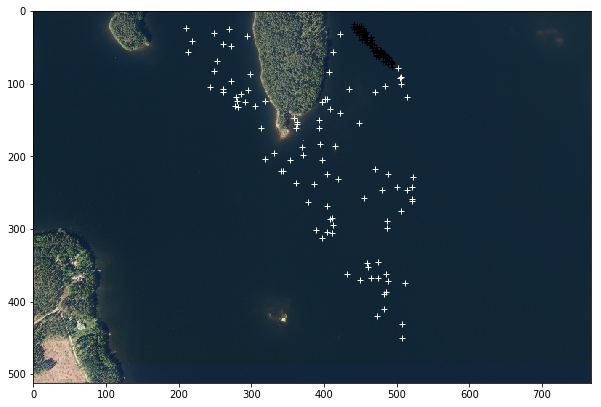

In [7]:
widths = len(set(i.column for i in sorted_images))
heights = len(set(i.row for i in sorted_images))
new_im = Image.new('RGB', (widths * 256, heights * 256))

x_offset = 0
y_offset = 0
previous_im = None
fig = plt.figure(figsize=(10, 10))
for im in sorted_images:
    if previous_im is not None and previous_im.column != im.column:
        x_offset += im.image.size[0]
    if previous_im is not None and previous_im.row != im.row:
        y_offset += im.image.size[1]
        x_offset = 0
    new_im.paste(im.image, (x_offset, y_offset))
    previous_im = im
    for dataset in datasets:
        plot_data_points(dataset["items"], im, x_offset, y_offset, dataset["color"])
plt.imshow(new_im)
plt.show()
